In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from foggy_statslib import core as fc
from foggy_statslib.stats.est import tsa as fsset
from foggy_statslib import fin as ff

/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# DATA

In [35]:
rfr = (
    pd.read_csv("data/fred_3m-tbill_secondary-yld.csv", index_col="DATE", parse_dates=True)
    .sort_index()
    .rename_axis(index="date")
    ["DTB3"].replace(".", None).astype(float).ffill()
    / 100 / 365
)
rfr

date
1954-01-04    0.000036
1954-01-05    0.000035
1954-01-06    0.000035
1954-01-07    0.000036
1954-01-08    0.000036
                ...   
2022-11-01    0.000111
2022-11-02    0.000111
2022-11-03    0.000111
2022-11-04    0.000110
2022-11-07    0.000113
Name: DTB3, Length: 17961, dtype: float64

In [19]:
spx = (
    pd.read_csv("data/investing-com_SPXTR_px.csv", index_col="Date", parse_dates=True)
    .sort_index()
    .rename_axis(index="date")
    ["Price"].str.replace(",", "").astype(float)
    .rename("SPX")
    # .pct_change()
)
spx

date
2001-08-13    1670.96
2001-08-14    1664.61
2001-08-15    1652.71
2001-08-16    1657.87
2001-08-17    1630.34
               ...   
2021-06-15    8833.68
2021-06-16    8786.18
2021-06-17    8782.58
2021-06-18    8667.76
2021-06-21    8789.52
Name: SPX, Length: 4999, dtype: float64

In [15]:
pput = (
    pd.read_csv("data/cboe_PPUT_px.csv", index_col="DATE", parse_dates=True)
    .sort_index()
    .rename_axis(index="date")
    ["PPUT"]
    # .pct_change()
)
pput.tail()

date
2022-10-28    1275.44
2022-10-31    1265.71
2022-11-01    1260.55
2022-11-02    1230.50
2022-11-03    1217.93
Name: PPUT, dtype: float64

# ANALYSIS

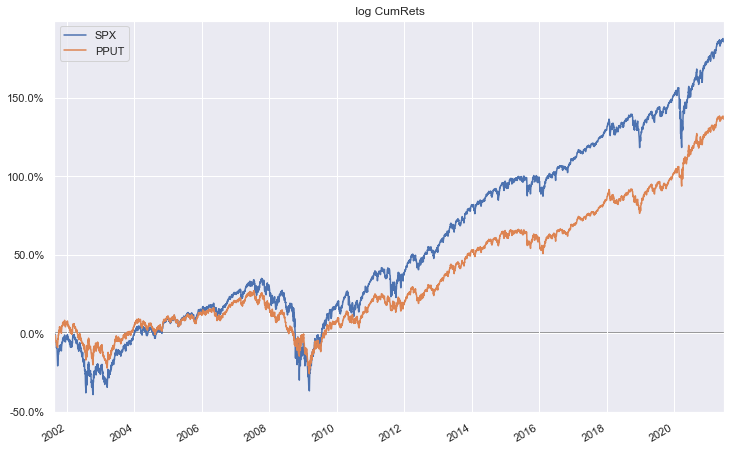

In [36]:
r = pd.DataFrame(
    {
        "SPX": spx,
        "PPUT": pput,
    }
)
r = fc.get_common_subsample(r)
r = r.pct_change()
r = r.subtract(
    rfr.reindex(index=r.index).ffill(),
    axis="index",
)


ff.plot_cum_r(r)
plt.show()

PPUT's smaller expected return is overwhelmed by its smaller volatility, giving it the Sharpe edge.

In [37]:
ff.get_est_perf_stats_of_r(r)

,Sharpe,t-stat,ER,Vol
SPX,0.536900,2.349476,0.097723,0.182014
PPUT,0.537594,2.352513,0.071820,0.133596


## alpha

In [38]:
# https://www.aqr.com/Insights/Research/White-Papers/Pathetic-Protection-The-Elusive-Benefits-of-Protective-Puts,
# starts earlier by 15 years
fsset.linreg(df=r.loc[:"2016", :], y="PPUT", x=["SPX"], smoothing_horizon=21).summary()

/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PPUT   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     168.5
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           9.48e-38
Time:                        23:10:54   Log-Likelihood:                 22271.
No. Observations:                3855   AIC:                        -4.454e+04
Df Residuals:                    3853   BIC:                        -4.453e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.751e-05   5.64e-05     -0.311      0.756      -0.000     9.3e-05
SPX            0.6898      0.053     12.982      0.000       0.586       0.794
==============================================================================
Omnibus:                     2686.190   Durbin-Watson:                   0.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70887.062
Skew:                           2.970   Prob(JB):                         0.00
Kurtosis:                      23.150   Cond. No.                         450.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 20 lags and without small sample correction
"""

In [39]:
-1.751e-05 * 21

-0.00036771

In [40]:
ff.get_alpha_t_stat_of_r(r.loc[:"2016", :], smoothing_horizon=21)

/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


of,SPX,PPUT
on,,
SPX,0.000000,-0.31059
PPUT,1.244374,0.00000


In [42]:
fsset.linreg(df=r, y="PPUT", x=["SPX"]).summary()

/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PPUT   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     800.5
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          1.78e-163
Time:                        23:28:12   Log-Likelihood:                 23867.
No. Observations:                4996   AIC:                        -4.773e+04
Df Residuals:                    4994   BIC:                        -4.772e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.705e-05   4.61e-05      0.586      0.558   -6.34e-05       0.000
SPX            0.6638      0.023     28.294      0.000       0.618       0.710
==============================================================================
Omnibus:                     4487.748   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496386.146
Skew:                           3.835   Prob(JB):                         0.00
Kurtosis:                      51.226   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 2 lags and without small sample correction
"""

In [41]:
ff.get_alpha_t_stat_of_r(r)

/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


of,SPX,PPUT
on,,
SPX,0.000000,0.586361
PPUT,0.626334,0.000000
